# Using Data Recorders

As ZnRND is at its core a package for scientific development, it comes with a powerfull data recording module which is demonstrated here.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import znrnd as rnd
import numpy as np

import matplotlib.pyplot as plt

from neural_tangents import stax
import optax

## Create a Data Generator

The first thing we need to do is create a data generator for the problem.

In [6]:
data_generator = rnd.data.MNISTGenerator()

## Define the Network

In [7]:
network = stax.serial(
    stax.Flatten(),
    stax.Dense(128),
    stax.Relu(),
    stax.Dense(10)
)

## Define the Data Recorders

In this case I want to track test and train data but at different intervals.

In [8]:
train_recorder = rnd.model_recording.JaxRecorder(
    name="train_recorder",
    loss=True,
    accuracy=True,
    update_rate=1
)
test_recorder = rnd.model_recording.JaxRecorder(
    name="test_recorder",
    loss=True,
    accuracy=True,
    update_rate=10
)

## Create Model and Prepare Recording

Before we train, we need to create a model and prepare the recorders. In this time, we add data and a model to the recorders. Note, any data can be added to the recorders here, even validation data.

In [9]:
production_model = rnd.models.NTModel(
            nt_module=network,
            optimizer=optax.adam(learning_rate=0.01),
            input_shape=(1, 28, 28, 1),
        )

In [10]:
train_recorder.instantiate_recorder(
    data_set=data_generator.train_ds
)
test_recorder.instantiate_recorder(
    data_set=data_generator.test_ds
)

## Create a training strategy

In order to train a model, we have to define a strategy how to train. 
The recorders and the model are an input to the strategy, as they record how the model trains.  

In [11]:
training_strategy = rnd.training_strategies.SimpleTraining(
    model=production_model, 
    loss_fn=rnd.loss_functions.CrossEntropyLoss(),
    accuracy_fn=rnd.accuracy_functions.LabelAccuracy(),
    recorders=[train_recorder, test_recorder]
)

## Train the model

In [12]:
batch_wise_loss = training_strategy.train_model(
    train_ds=data_generator.train_ds,
    test_ds=data_generator.test_ds,
    batch_size=32,
    recorders=[train_recorder, test_recorder],
    epochs=100
)

Epoch: 100: 100%|███████████████████████████████| 100/100 [00:06<00:00, 14.93batch/s, accuracy=0.88]


## Checking the Results

Now let's use the export function of the reporter to get access to an easy to plot dataclass with all of the metrics we recorded.

In [14]:
train_report = train_recorder.gather_recording()
test_report = test_recorder.gather_recording()

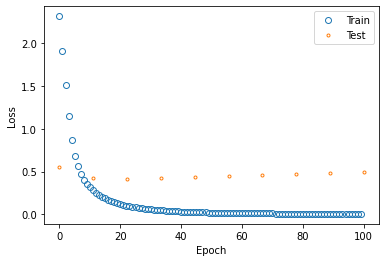

In [15]:
plt.plot(train_report.loss, 'o', mfc='None', label="Train")
plt.plot(np.linspace(0, 100, 10), test_report.loss, '.', mfc="None", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

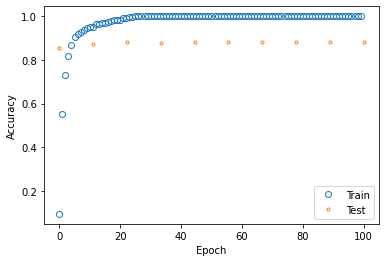

In [16]:
plt.plot(train_report.accuracy, 'o', mfc='None', label="Train")
plt.plot(np.linspace(0, 100, 10), test_report.accuracy, '.', mfc="None", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Exporting the Data

The final thing to do is export the data to a persistant format. During training, this is partially done automatically. However, the recorders have no way of knowing when training is finished and therefore, you should always run the following to make sure the last of your saved data is put into the database before ending the session.

In [17]:
train_recorder.dump_records()
test_recorder.dump_records()